# CAP 394 - Brazilian Savannas Vegetation Areas Identification Using MODIS MOD13Q1 Data

## 1. Introduction

In this work, the aim is to use MODIS MOD13Q1 data to identify remaining areas of brazilian savannas. The data are available through an INPE server, accessed with the _wtss_ python package. 6 data types will be used:

+ Digital Number:
    + Blue
    + Red
    + NIR
    + MIR
+ Vegetation Indexes:
    + NDVI
    + EVI
    
The identification of the brazilian savannas remaining areas is going to be done using deep learning algorithms. To use such type of algorithms, a training set have to be used, in this case, data from the PRODES project can be used.

<img src="./Images/graph.png" width="500">

Below can be found some the packages needed in the project.

In [1]:
from wtss import wtss
import numpy
import matplotlib.pyplot as plt
import time
import shapefile as shp
from shapely.geometry import Point
from shapely.geometry.polygon import Polygon
import matplotlib.animation as animation
from IPython.display import HTML

This next function is a progressbar. It can be used to show the processing's status, and some notion of the needed time to process can be made.

In [2]:
# Print iterations progress
# Source: https://stackoverflow.com/questions/3173320/text-progress-bar-in-the-console
def printProgressBar (iteration, total, prefix = '', suffix = '', decimals = 1, length = 100, fill = '█'):
    """
    Call in a loop to create terminal progress bar
    @params:
        iteration   - Required  : current iteration (Int)
        total       - Required  : total iterations (Int)
        prefix      - Optional  : prefix string (Str)
        suffix      - Optional  : suffix string (Str)
        decimals    - Optional  : positive number of decimals in percent complete (Int)
        length      - Optional  : character length of bar (Int)
        fill        - Optional  : bar fill character (Str)
    """
    percent = ("{0:." + str(decimals) + "f}").format(100 * (iteration / float(total)))
    filledLength = int(length * iteration // total)
    bar = fill * filledLength + '-' * (length - filledLength)
    print('\r%s |%s| %s%% %s' % (prefix, bar, percent, suffix), end = '\r')
    # Print New Line on Complete
    if iteration == total:
        print()

##  2. Data acquisition

Time series data will be used, so, somehow they have to be retrieved. In this project, this date will be acquired using a python package called **wtss**. This package can be used to access data cubes and its metadata. More information about the package can be found in [here](https://github.com/e-sensing/wtss.py). The package is used to access the data, but first the data must be made available by a provider, in this project, data provided by INPE is going to be used, from the product MOD13Q1 of the MODIS data aquisition platform.

### 2.1 Time Series of a Point

The function below uses the latitude and longitude of a point to retrieve the corresponding time series. Other input parameters are the coverage wanted and the start and end dates of the series.

The output if it are two arrays: one with the dates and one with the time series.

In [3]:
def retrieveDataFromPoint(lat, long, series, coverage, date1, date2):
    w = wtss("http://www.esensing.dpi.inpe.br")
    ts = w.time_series(series, coverage, lat, long, start_date=date1, end_date=date2)
    return ts.timeline, ts[coverage]

Below a line graph shows how a time series obtained with this function can be seen. In this case, an NDVI series for an area affected by the Fundão dam disaster.

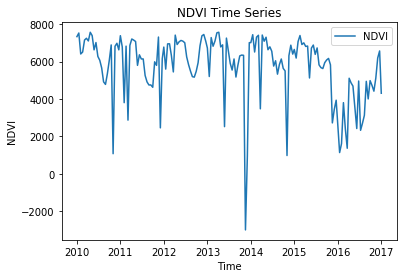

In [4]:
ts, cov = retrieveDataFromPoint(-20.235905, -43.417123, "MOD13Q1", "ndvi", "2010-01-01", "2017-01-01")
plt.plot(ts, cov, label="NDVI")
plt.title("NDVI Time Series")
plt.xlabel("Time")
plt.ylabel("NDVI")
plt.legend()
plt.show()

### 2.2 Outliers

The data used in the project is not any close of being perfectly clean. Many things can cause deviations on satellite data obtained with optical sensors, the biggest problem being the cloud and cloud shadows coverage in a scene. This two features have extreme different spectral behavior, the cloud being responsible for a saturation area in the picture, and the could shadow being responsible for a black area, with low signal. 

This type of coverage (clouds and clouds shadows) is not wanted in the project, due to the fact it hides the information of the ground reflectance under it. In this case, some algorithms can be used to minimize the effects of the cloud influence in the time series.

In the project, clouds and cloud's shadows are considered outliers, and therefore must be removed or diminished.

The function used to filter the outliers can be found below <span style="color:red">(NOT FINAL, just for the tests)</span>.

In [5]:
# HANTS here in the future

# Removing outliers - algorythms only for the tests (this is NOT HANTS)
# Paper: https://www.mdpi.com/2072-4292/5/12/6159
def remove_outliers(ts):
    ts_corrected = ts.copy()
    per = 1/100

    for j in range(1, len(ts_corrected) - 1):
        if (ts[j]-ts[j-1]<-per*ts[j-1]) and (ts[j]-ts[j+1]<-per*ts[j+1]):
            ts_corrected[j] = (ts[j-1]+ts[j+1])/2

    return ts_corrected

An example of this algorithm's application can be seen below:

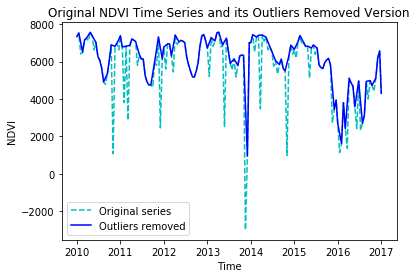

In [6]:
cov_out = remove_outliers(cov)
plt.plot(ts, cov, "--c", label="Original series")
plt.plot(ts, cov_out, "b", label="Outliers removed")
plt.title("Original NDVI Time Series and its Outliers Removed Version")
plt.xlabel("Time")
plt.ylabel("NDVI")
plt.legend()
plt.show()

Removing the outliers is still not enough, the series need to be filtered i order to have a smother shape, what can improve the accuracy of the classification algorithms. The function that filters the time series can be found below <span style="color:red">(NOT FINAL, just for the tests)</span>.

In [7]:
# savitzky golay filtering method.
# Source: https://scipy-cookbook.readthedocs.io/items/SavitzkyGolay.html
def filter_savitzky_golay(ts):
    from math import factorial
    window_size = 5
    order = 3
    deriv = 0
    rate = 1

    y = numpy.asarray(ts)

    try:
        window_size = numpy.abs(numpy.int(window_size))
        order = numpy.abs(numpy.int(order))
    except ValueError:
        print("window_size and order have to be of type int")
    if window_size % 2 != 1 or window_size < 1:
        raise TypeError("window_size size must be a positive odd number")
    if window_size < order + 2:
        raise TypeError("window_size is too small for the polynomials order")
    order_range = range(order + 1)
    half_window = (window_size - 1) // 2
    # precompute coefficients
    b = numpy.mat([[k ** i for i in order_range] for k in range(-half_window, half_window + 1)])
    m = numpy.linalg.pinv(b).A[deriv] * rate ** deriv * factorial(deriv)
    # pad the signal at the extremes with
    # values taken from the signal itself
    firstvals = y[0] - numpy.abs(y[1:half_window + 1][::-1] - y[0])
    lastvals = y[-1] + numpy.abs(y[-half_window - 1:-1][::-1] - y[-1])
    y = numpy.concatenate((firstvals, y, lastvals))
    return numpy.convolve(m[::-1], y, mode='valid')

An example of this algorithm's application can be seen below:

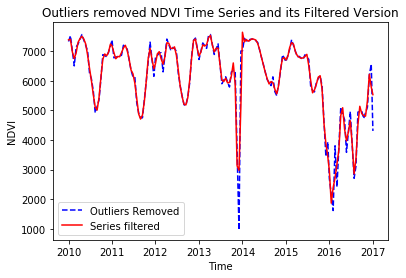

In [8]:
cov_filt = filter_savitzky_golay(cov_out)
plt.plot(ts, cov_out, "--b", label="Outliers Removed")
plt.plot(ts, cov_filt, "r", label="Series filtered")
plt.title("Outliers removed NDVI Time Series and its Filtered Version")
plt.xlabel("Time")
plt.ylabel("NDVI")
plt.legend()
plt.show()

### 2.3 Time Series in a Matrix

The function above _retrieveDataFromPoint( )_  gets the time series for a certain coordinate. This is useful to analyze the profile of a single point, but the aim is to find the areas, so it has to be spatialized. The function below gets one single time series in order to know the size of the array needed (lat, long and total number of dates). With the series dimensions, it creates a matrix to receive all the data retrieve within a polygon obtained via a shapefile saved to the computer.

The retrieval is made for a single data type at a time (blue, red, nir, mir, NDVI or EVI). This data is used in the identification of the brazilian savannas areas, and while they are being retrieved, they are also being filtered and having their outliers removed/diminished. <span style="color:red">(Function still not final, outliers removed and filtering still have to be implemented correctly)</span>.

In [9]:
def retrieveDataMatrix(lat1, lat2, long1, long2, t1, t2, series, coverage, poly):

    # Shows info
    print("------------------------- RETRIEVING DATA TO A MATRIX --------------------------")

    # server data
    w = wtss("http://www.esensing.dpi.inpe.br")

    # gets coverage info
    cv_scheme = w.describe_coverage(series)

    # range i (height) and j (width) based on the spatial resolution
    r_i = int((lat2-lat1)/cv_scheme["spatial_resolution"]["y"])+1
    r_j = int((long2-long1)/cv_scheme["spatial_resolution"]["x"])+1

    # Print info about the n° of lines and columns
    print("\n",r_i, " lines and  ", r_j, "columns")

    y = (lat1+(lat2-lat1)/2)
    x = (long1+(long2-long1)/2)
    [time_series, data] = retrieveDataFromPoint(y, x, series, coverage, t1, t2)

    # creates the array to receive data
    all_data = numpy.zeros((r_i, r_j, len(time_series)))

    # percentage stuff
    printProgressBar(0, r_i * r_j, prefix='Progress:', suffix='Complete', length=50)
    a = 1

    # loop that get all things done (get data of a point, filter and remove the outliers)
    for i in range(r_i):
        for j in range(r_j):
            y = lat1+i*cv_scheme["spatial_resolution"]["y"]
            x = long1+j*cv_scheme["spatial_resolution"]["x"]

            pt = Point(x,y)

            if poly.contains(pt):
                try:
                    [time_series, data] = retrieveDataFromPoint(y, x, series, coverage, t1, t2)
                    all_data[i, j, :] = filter_savitzky_golay(remove_outliers(data))
                except:
                    all_data[i, j, :] = None
            else:
                all_data[i, j, :] = None
            printProgressBar(a, r_i * r_j, prefix='Progress:', suffix='Complete', length=50)
            a = a+1
            
    return time_series, all_data, r_i, r_j

## 3. MODIS Data Example

Below, an example of the data to be used can be seen. A polygon of a little area is used, but a larger area, like a municipality, can be used. In the project, a larger area should be used.

In the next code chunk, the shapefile with the interest area polygon is opened.

In [10]:
# opens the shapefile
sf = shp.Reader("./Shape/sao_desiderio")
sfRec = sf.records()
n = 0
m = 1
coor = ''
coorDict = {}
matplotDict = []

for shape in sf.shapeRecords(): #Iterate through shapes in shapefile
    x = [i[0] for i in shape.shape.points[:]] #Initially for use in matplotlib to check shapefile
    y = [i[1] for i in shape.shape.points[:]] #Initially for use in matplotlib to check shapefile
    for i in x:
        matplotDict.append((x[x.index(i)],y[x.index(i)])) #Convert coordinates to be read by Shapely pkg

    poly = Polygon(matplotDict) #main
    n += 1

The format of the shapefile can be seen in the following figure. The area is the municipality of São Desidério, which is located at the west region of the Bahia State, and is inserted in the Cerrado biome.

(-46.42017066089997,
 -44.46155981110001,
 -13.523579478429468,
 -12.234517550391313)

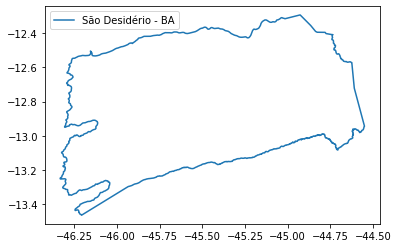

In [11]:
x,y = poly.exterior.xy
plt.plot(x,y, label="São Desidério - BA")
plt.legend()
plt.axis("equal")

Now, the data is retrieved and a little animation is created.

In [ ]:
t = time.time()
[ts, all, i, j] = retrieveDataMatrix(lat1=min(y), lat2=max(y), long1=min(x), long2=max(x), t1="2017-01-01", t2="2018-01-01", series="MOD13Q1", coverage="ndvi", poly=poly)
print("Total time: %.3f minutes" % ((time.time()-t)/60))

------------------------- RETRIEVING DATA TO A MATRIX --------------------------

 562  lines and   854 columns


In [ ]:
fig, ax = plt.subplots()

ax.set_xlim((0, j))
ax.set_ylim((0, i))

im = ax.imshow(all[:,:,0], cmap="summer")

def init():
    im.set_data(all[:,:,0])
    return (im,)

def animate(i):
    data_slice = all[:,:,i]
    ax.set_title(str(ts[i]))
    im.set_data(data_slice)
    return (im,)

anim = animation.FuncAnimation(fig, animate, init_func=init, frames=all.shape[2], interval=200, blit=True)
timelapse = HTML(anim.to_jshtml())
plt.close()
timelapse

A frame of the previous animation can be found below.

In [ ]:
plt.imshow(all[:,:,0], cmap="summer")
plt.plot()

## 4. PRODES Data

PRODES provides the deforestation areas for the entire Cerrado biome, in the _shapefile_ format. In this case, the areas are acquired by visual interpretation, done by trained analysts, what guarantee a high level of accuracy. The idea is to use PRODES data to identify training areas, and then apply the algorithms to the savannas identification.

A simple visualization of the PRODES data can be seen below, as well as an approximation to the study area.

<img src="./Images/prodes.png" width="700">

The data is composed of a series of polygons, which represent the deforestation of the Cerrado until the end of 2018. This data is then cropped to the study area, like in the code below.

In [ ]:
# Still to be done

With the PRODES cropped polygons, then random points can be selected in the "empty" space, the time series of this points can be collected and recorded as "training samples" for the classification algorithms.

## 5. Classification

In this part, some time series remote sensing classification method can be used. Still to be decided which one is going to be used, but there is the intent to use more than one, in order to compare both.

## 6. Conclusion

With this methodology is expected to achieve a classification of the land cover/land use of the study area, regarding two classes: deforested area and not-deforested area. The accuracy expected is not high, in comparison with the product of PRODES.

Behind all the methods here described is the intention to automatize the PRODES process. High quality results, comparable with the PRODES product are not possible to achieve with such a simple work flow, but it can be the right step in the direction of the algorithms to be used in the creation of the PRODES product in the future.